**Task: to conduct AB test and analyse the data. We implemented new post recommendations algorithm for users from group 2, group 1 was used as a control group 
The main hypothesis is that the new algorithm in the 2nd group will lead to CTR increasing**

In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
from scipy import stats
import matplotlib.pyplot as plt
import hashlib
from tqdm.auto import tqdm

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20221120',
                      'user':'', 
                      'password':''
                     }

In [3]:
query = """


SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-11-02' and '2022-11-08'
    and exp_group in (1,2)
GROUP BY exp_group, user_id

"""


df = ph.read_clickhouse(query, connection=connection)
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [4]:
df.groupby('exp_group', as_index = False).count()

,exp_group,user_id,likes,views,ctr
0,1,10079,10079,10079,10079
1,2,9952,9952,9952,9952


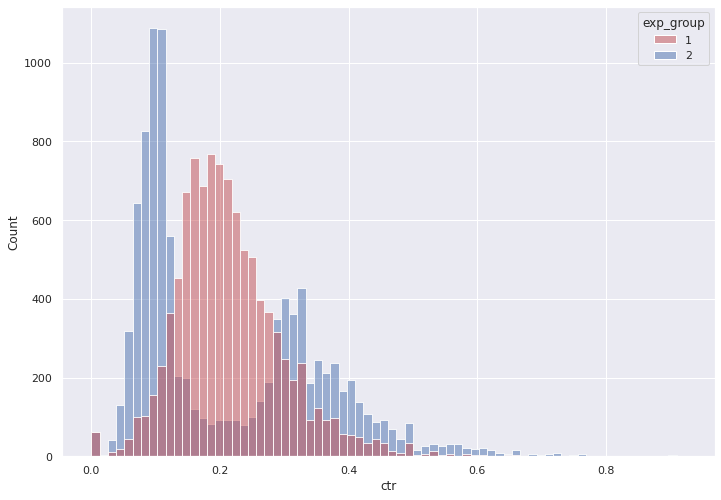

In [5]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

<AxesSubplot:xlabel='exp_group', ylabel='ctr'>

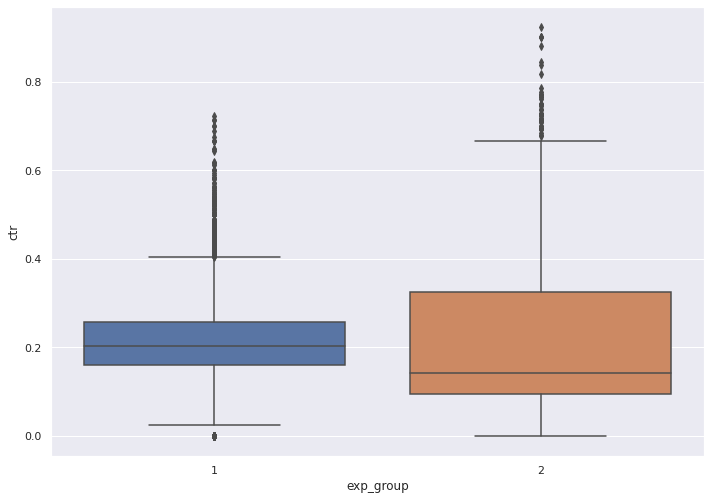

In [6]:
sns.boxplot(x="exp_group", y="ctr", data=df)

**Preliminary visualization shows that the distribution of CTR in control group 1 is similar to a normal distribution, and in test group 2 it is bimodal distribution**

**Further in the document several test are conducted and analysed as an example**

**1. T-test**

In [7]:
stats.ttest_ind(df[df.exp_group == 1].ctr, df[df.exp_group == 2].ctr, equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

**According to the resulting p-value we cannot reject the null hypothesis (about the equality of the means), however, the distribution of group № 2 is not normal, so the result cannot be trusted**

**2. Mann–Whitney test**

In [8]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

**According to the resulting p-value we cannot reject the null hypothesis (about the equality of the means), however, the distribution of group № 2 is not normal, so the result cannot be trusted**

**3. Mann–Whitney test**

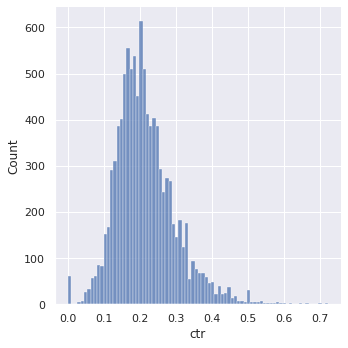

In [9]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-11-02' and '2022-11-08'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

group1 = df[df.exp_group == 1].copy()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.displot(group1.ctr, 
             kde = False)
group2 = df[df.exp_group == 2].copy()

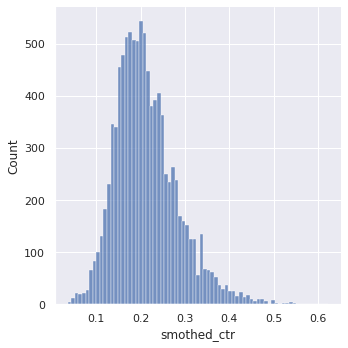

In [10]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.displot(group1.smothed_ctr, 
             kde = False)

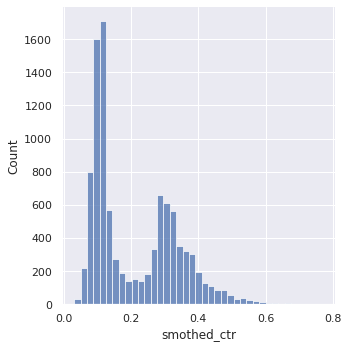

In [11]:
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.displot(group2.smothed_ctr, 
             kde = False)

In [12]:
stats.ttest_ind(group1.smothed_ctr, group2.smothed_ctr, equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

In [13]:
stats.mannwhitneyu(group1.smothed_ctr, 
                   group2.smothed_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56925125.0, pvalue=1.6163964114270227e-61)

In [14]:
group1

,exp_group,user_id,likes,views,ctr,smothed_ctr
0,1,109963,3,15,0.200000,0.202007
1,1,26117,32,141,0.226950,0.226302
2,1,138232,18,73,0.246575,0.244104
3,1,26295,33,122,0.270492,0.268033
4,1,18392,7,32,0.218750,0.217301
...,...,...,...,...,...,...
20020,1,31540,8,45,0.177778,0.180803
20021,1,23359,23,91,0.252747,0.250418
20024,1,110956,3,16,0.187500,0.192387
20026,1,132567,45,296,0.152027,0.152957


**Based on the results of checking the smoothed CTR, both the t-test and the Mann-Whitney test obtained a statistically significant difference. The change of p-value for of the t-test for smoothed CTR against usual CTR probably occured, because we smoothed out the CTR values (and the t-test is highly dependent on outliers)**

**4. Poisson bootstrap check**

<AxesSubplot:ylabel='Count'>

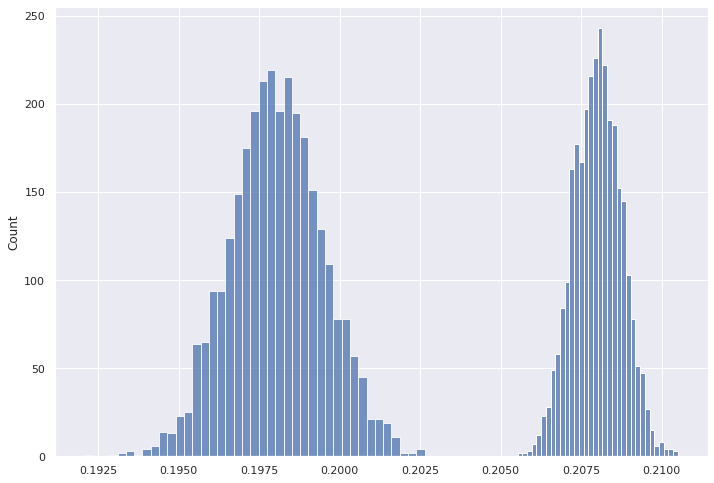

In [15]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=3000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-11-02' and '2022-11-08'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""


df = ph.read_clickhouse(q, connection=connection)

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

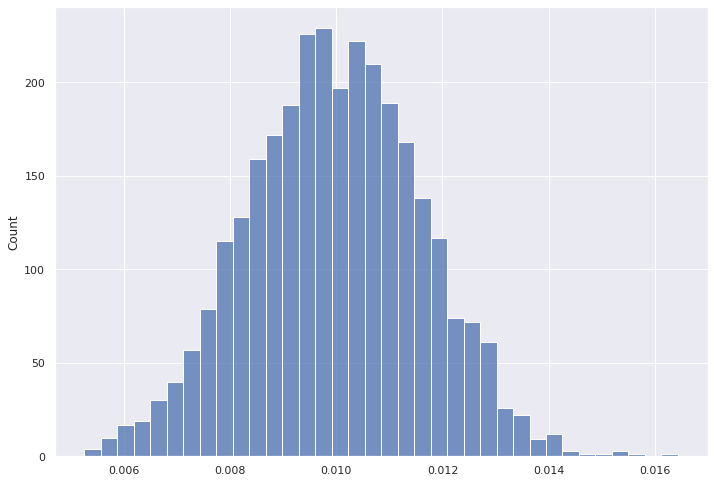

In [16]:
#Difference between global CTR

sns.histplot(ctr1 - ctr2)


**The distribution of the CTR difference does not include 0, so we conclude that there is a statistically significant difference**

**5. Bucket testing**

In [17]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-11-02' and '2022-11-08'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_bucket = ph.read_clickhouse(q, connection=connection)

stats.mannwhitneyu(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [18]:
stats.ttest_ind(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

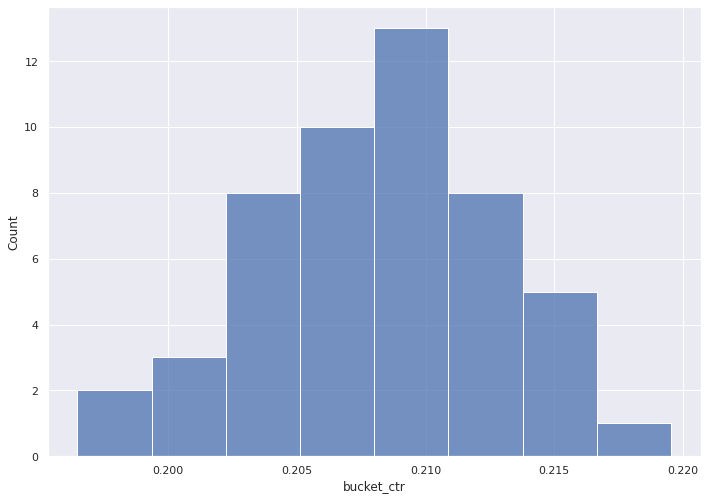

In [19]:
sns.histplot(df_bucket[df_bucket.exp_group == 1].bucket_ctr)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

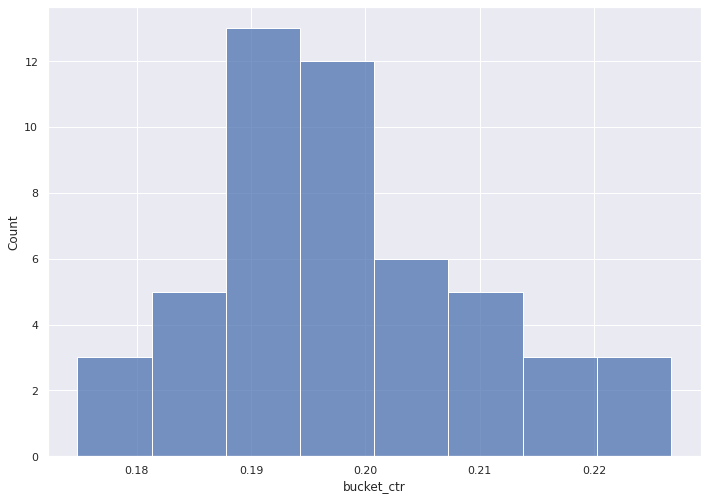

In [20]:
sns.histplot(df_bucket[df_bucket.exp_group == 2].bucket_ctr)

**The results of the t-test and the Mann-Whitney test also show a statistically significant difference. In this case, the t-test showed a statistically significant difference, most likely due to the fact that the distributions within the bucket turned out to be close to normal**

**Conclusion from the tests carried out:
We compared the CTR of the control and test groups by 5 different methods. With the exception of a direct comparison by the t-test (which is rather inaccurate based on the distributions), we got a statistically significant difference, and in the direction of worsening CTR when introducing a new recommendation algorithm. Let's try to find out if the change was caused by external factors**

In [22]:
df.groupby('exp_group', as_index = False).count()

,exp_group,user_id,likes,views,ctr
0,1,10079,10079,10079,10079
1,2,9952,9952,9952,9952


In [23]:
df.groupby('exp_group', as_index = False).agg({'ctr':'mean'})

,exp_group,ctr
0,1,0.215605
1,2,0.214419


In [25]:
df.groupby('user_id', as_index = False).agg({'exp_group':'count'}).exp_group.max()

1

In [26]:
df[(df['exp_group'] == 2) & (df['ctr'] < 0.2)]

,exp_group,user_id,likes,views,ctr
5,2,131473,14,134,0.104478
6,2,23985,7,87,0.080460
7,2,24523,11,101,0.108911
14,2,6911,2,38,0.052632
15,2,119153,2,24,0.083333
...,...,...,...,...,...
20018,2,24633,7,66,0.106061
20019,2,109317,2,26,0.076923
20023,2,16512,1,15,0.066667
20025,2,17146,0,10,0.000000


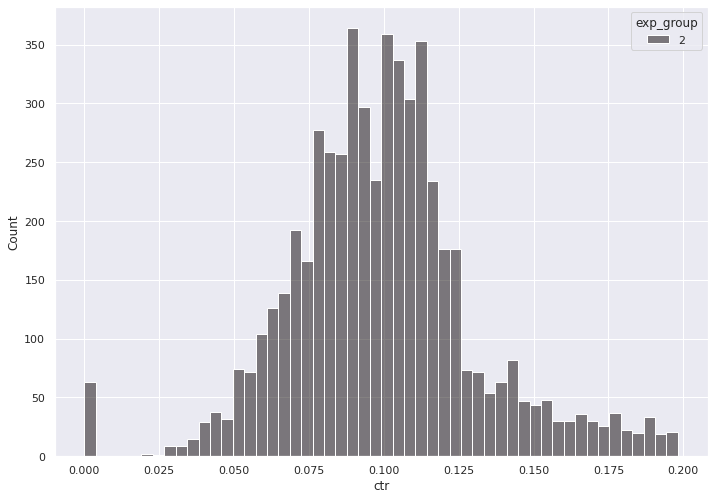

In [27]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df[(df['exp_group'] == 2) & (df['ctr'] < 0.2)], 
              x='ctr', 
              hue='exp_group', 
              palette = 'mako',
              alpha=0.5,
              kde=False)

In [28]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr,
    os,
    gender,
    source,
    country,
    city
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-11-02' and '2022-11-08'
    and exp_group in (1,2)
GROUP BY exp_group, user_id, os, gender, source, country, city
"""

df2 = ph.read_clickhouse(q, connection=connection)


In [29]:
df2.groupby('exp_group', as_index = False).agg({'ctr':'mean'})

,exp_group,ctr
0,1,0.215605
1,2,0.214419


In [65]:
df2.groupby(['exp_group', 'os'], as_index = False).agg({'user_id':'count'})

,exp_group,os,user_id
0,1,Android,6532
1,1,iOS,3547
2,2,Android,6409
3,2,iOS,3543


In [31]:
df2.groupby(['exp_group', 'source'], as_index = False).agg({'user_id':'count'})

,exp_group,source,user_id
0,1,ads,4720
1,1,organic,5359
2,2,ads,4694
3,2,organic,5258


In [32]:
df2.groupby(['exp_group', 'gender'], as_index = False).agg({'user_id':'count'})

,exp_group,gender,user_id
0,1,0,4535
1,1,1,5544
2,2,0,4445
3,2,1,5507


In [33]:
df2.groupby(['exp_group', 'country'], as_index = False).agg({'user_id':'count'})

,exp_group,country,user_id
0,1,Azerbaijan,90
1,1,Belarus,212
2,1,Cyprus,8
3,1,Estonia,18
4,1,Finland,98
5,1,Kazakhstan,201
6,1,Latvia,10
7,1,Russia,8855
8,1,Switzerland,8
9,1,Turkey,78


In [34]:
df4 = df2[(df2['exp_group'] == 2) & (df2['ctr'] < 0.2)]

In [35]:
df4.user_id.count()

5486

In [36]:
df4.head()

,exp_group,user_id,likes,views,ctr,os,gender,source,country,city
4,2,130139,6,78,0.076923,Android,0,organic,Russia,Krasnodar
5,2,137342,3,48,0.062500,Android,1,organic,Russia,Omsk
31,2,111829,11,95,0.115789,Android,0,organic,Russia,Vysokovsk
35,2,31955,11,80,0.137500,iOS,1,ads,Russia,Rostov
38,2,23964,9,87,0.103448,iOS,0,ads,Russia,Saratov


In [37]:
df4.groupby(['os'], as_index = False).agg({'user_id': 'count'})

,os,user_id
0,Android,3477
1,iOS,2009


In [38]:
df4.groupby(['source'], as_index = False).agg({'user_id': 'count'})

,source,user_id
0,ads,2569
1,organic,2917


In [39]:
df4.groupby(['gender'], as_index = False).agg({'user_id': 'count'})

,gender,user_id
0,0,2428
1,1,3058


In [40]:
df4[df4['country'] == 'Russia'].groupby(['city'], as_index = False).agg({'user_id': 'count'}).sort_values(by='user_id', ascending=False)

,city,user_id
438,Moscow,753
616,Saint Petersburg,230
605,Rostov,72
501,Novosibirsk,66
861,Yekaterinburg,64
...,...,...
582,Privolzhsk,1
581,Privolnoye,1
255,Kartaly,1
579,Primorsko-Akhtarsk,1


In [41]:
df5 = df2[(df2['exp_group'] == 2) & (df2['ctr'] >= 0.2)]

In [42]:
df5.user_id.count()

4466

In [43]:
df5.groupby(['os'], as_index = False).agg({'user_id': 'count'})

,os,user_id
0,Android,2932
1,iOS,1534


In [44]:
df5.groupby(['source'], as_index = False).agg({'user_id': 'count'})

,source,user_id
0,ads,2125
1,organic,2341


In [45]:
df5.groupby(['gender'], as_index = False).agg({'user_id': 'count'})

,gender,user_id
0,0,2017
1,1,2449


In [46]:
df5[df5['country'] == 'Russia'].groupby(['city'], as_index = False).agg({'user_id': 'count'}).sort_values(by='user_id', ascending=False)

,city,user_id
400,Moscow,599
544,Saint Petersburg,212
752,Yekaterinburg,65
449,Novosibirsk,50
493,Perm,46
...,...,...
345,Laishevo,1
341,Kuznetsovo,1
337,Kuterem,1
336,Kushva,1


**Just in case, it was checked that the splitting system works correctly and the CTR distribution of the test group isn't caused of some external factors. Next, we check the change in CTR over time**

In [47]:

q = """
SELECT toDate(time) as date,
    exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr,
    os,
    gender,
    source,
    country,
    city
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-11-02' and '2022-11-08'
    and exp_group in (1,2)
GROUP BY date, exp_group, user_id, os, gender, source, country, city
"""

df6 = ph.read_clickhouse(q, connection=connection)


In [48]:
df6.head()

,date,exp_group,user_id,likes,views,ctr,os,gender,source,country,city
0,2022-11-02,1,22354,5,11,0.454545,Android,0,ads,Russia,Bataysk
1,2022-11-03,2,7633,7,44,0.159091,Android,0,ads,Russia,Michurinsk
2,2022-11-05,2,126328,3,12,0.250000,Android,1,organic,Russia,Moscow
3,2022-11-04,1,117643,7,39,0.179487,iOS,0,organic,Russia,Uryupinsk
4,2022-11-06,1,129919,3,19,0.157895,iOS,0,organic,Ukraine,Kyiv


<AxesSubplot:xlabel='date', ylabel='ctr'>

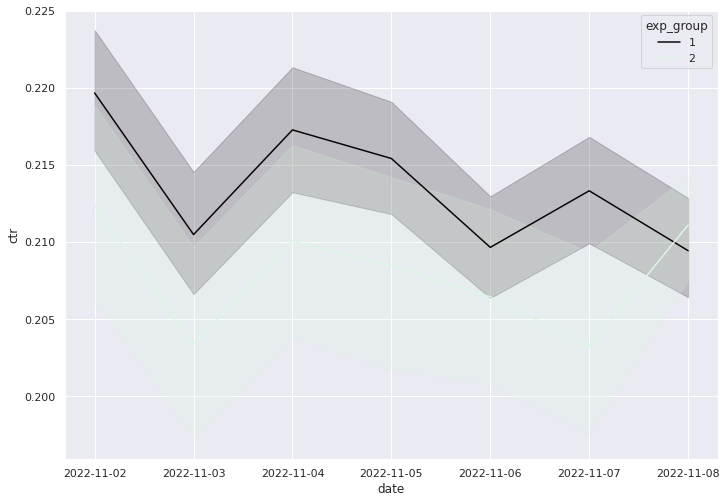

In [49]:
sns.lineplot(data=df6, hue='exp_group', x='date', y='ctr', palette='mako')

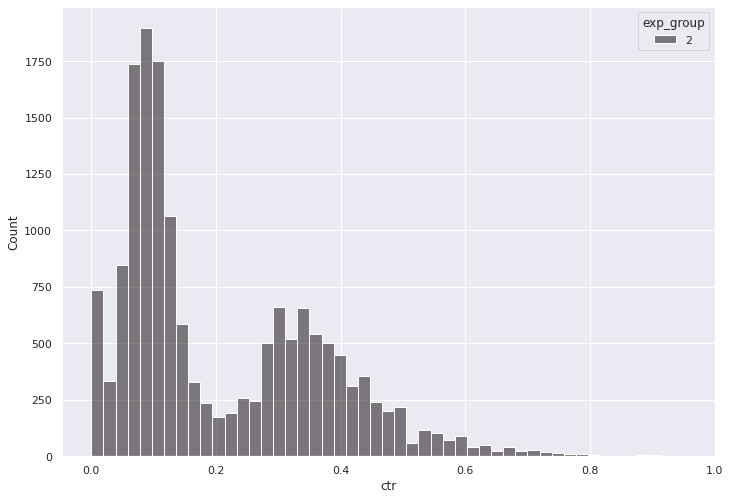

In [51]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df6[(df6['exp_group'] == 2) & (df6['date'] < '2022-11-08')], 
              x='ctr', 
              hue='exp_group', 
              palette = 'mako',
              alpha=0.5,
              kde=False)

In [79]:
df6[(df6['exp_group'] == 2) & (df6['date'] < '2022-11-08')].ctr.mode()

0    0.0
dtype: float64

In [52]:
df6[(df6['exp_group'] == 2) & (df6['date'] < '2022-11-08')].ctr.median()

0.1304347826086956

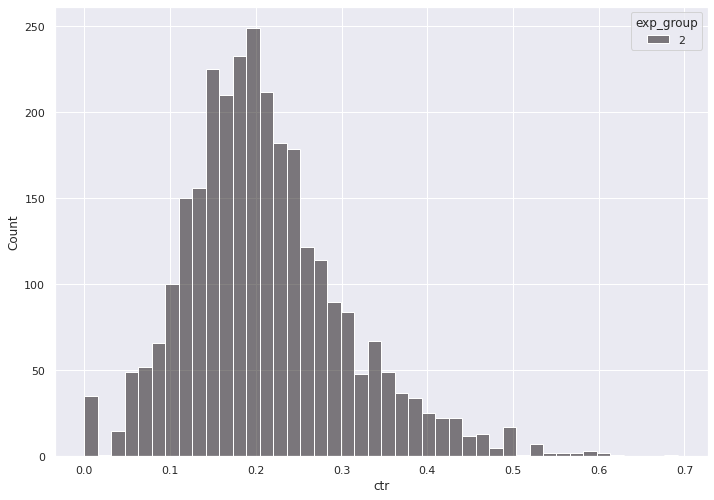

In [53]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df6[((df6['exp_group'] == 2) & (df6['date'] < '2022-11-09') & (df6['date'] >= '2022-11-08'))], 
              x='ctr', 
              hue='exp_group', 
              palette = 'mako',
              alpha=0.5,
              kde=False)

In [54]:
df6[(df6['exp_group'] == 2) & (df6['date'] < '2022-11-09') & (df6['date'] >= '2022-11-08')].ctr.mean()

0.21111843974601208

In [80]:
df6[((df6['exp_group'] == 2) & (df6['date'] < '2022-11-09') & (df6['date'] >= '2022-11-08'))].ctr.mode()

0    0.2
dtype: float64

In [55]:
df6[((df6['exp_group'] == 2) & (df6['date'] < '2022-11-09') & (df6['date'] >= '2022-11-08'))].ctr.median()

0.2

<AxesSubplot:xlabel='date', ylabel='ctr'>

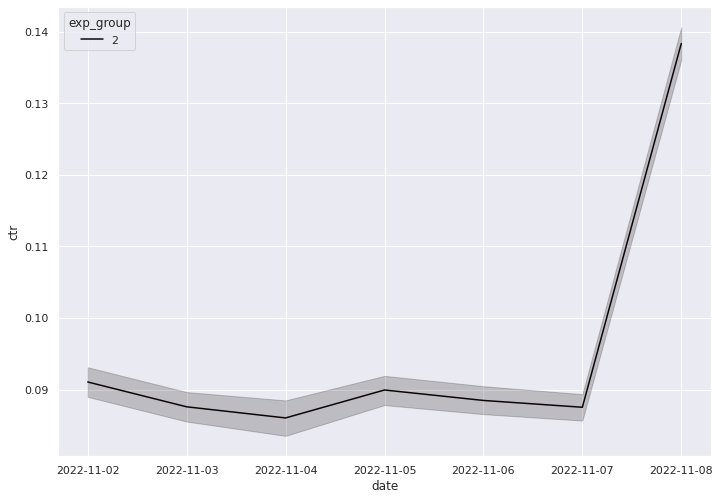

In [56]:
sns.lineplot(data=df6[(df6['exp_group'] == 2) & (df6['ctr'] < 0.2)], x='date', y='ctr', hue='exp_group', palette='mako')

<AxesSubplot:xlabel='date', ylabel='ctr'>

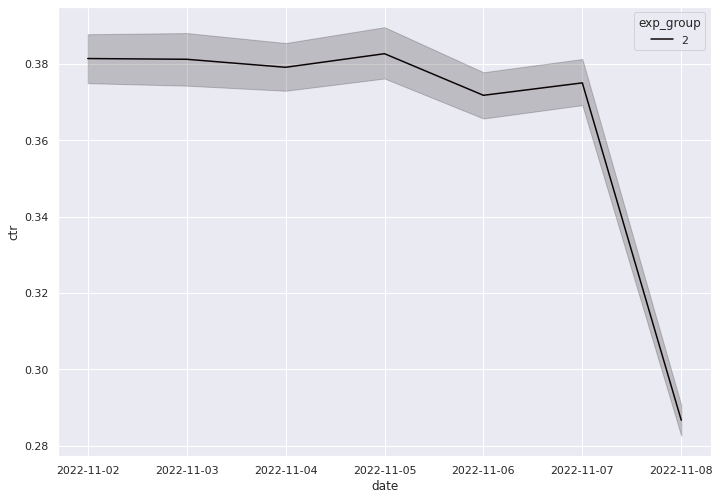

In [57]:
sns.lineplot(data=df6[(df6['exp_group'] == 2) & (df6['ctr'] > 0.2)], x='date', y='ctr', hue='exp_group', palette='mako')

**The following pattern of change in the distribution of CTR in the test group was obtained: from November 2 to November 7, 2022, CTRs have a bimodal distribution with the first mode close to 0, and on November 8, 2022, CTRs have a unimodal distribution with a mode of 0.2. External factors that could affect the test group were not identified. <br>
The presumed reason for this may be that the post recommendation algorithm needs a learning period to work correctly, after which it starts to issue better recommendations based on user preferences**

**Conclusion: At the moment it is not recommended to implement the recommendation algorithm to all users, because we cannot be sure that it will not worsen the CTR metric in the long term (or that it will eventually increase the CTR at all). It is recommended to repeat the test for a longer period of time (for example, 2 weeks)**